In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import matplotlib as mpl

%matplotlib inline

# customize matplotlib styles
mpl.rc('lines', linewidth=4) # default linewidth
mpl.rc('lines', dash_capstyle='round') # default dashed line capstyle
mpl.rc('lines', solid_capstyle='round') # default solid line capstyle
mpl.rc('xtick', labelsize=20) # default label size for xtick
mpl.rc('ytick', labelsize=20) # default label size for ytick
mpl.rc('axes', titlesize=30) # default title size

# Physical constants

In [4]:
q0 = 1.6e-19 # electron charge in Coulomb
eV = 1.6e-19 # electron volt in Jouls

# Give the input directories as a list

In [5]:
directories = list()

directories.append(os.path.expanduser("~/research/monte_carlo_fiber"))

# directories.append(os.path.expanduser("~/research/monte_carlo_davoody_realistic_random_5to20_bids_1.5nm_thick"))
# directories.append(os.path.expanduser("~/research/monte_carlo_davoody_realistic_random_5to20_bids_2nm_thick"))
# directories.append(os.path.expanduser("~/research/monte_carlo_davoody_realistic_random_5to20_bids_2.5nm_thick"))
# directories.append(os.path.expanduser("~/research/monte_carlo_davoody_realistic_random_5to20_bids_3nm_thick"))
# directories.append(os.path.expanduser("~/research/monte_carlo_davoody_realistic_random_5to20_bids_3.5nm_thick"))
# directories.append(os.path.expanduser("~/research/monte_carlo_davoody_realistic_random_5to20_bids_4nm_thick"))

# read the current data

steady state drain current: 0.00e+00


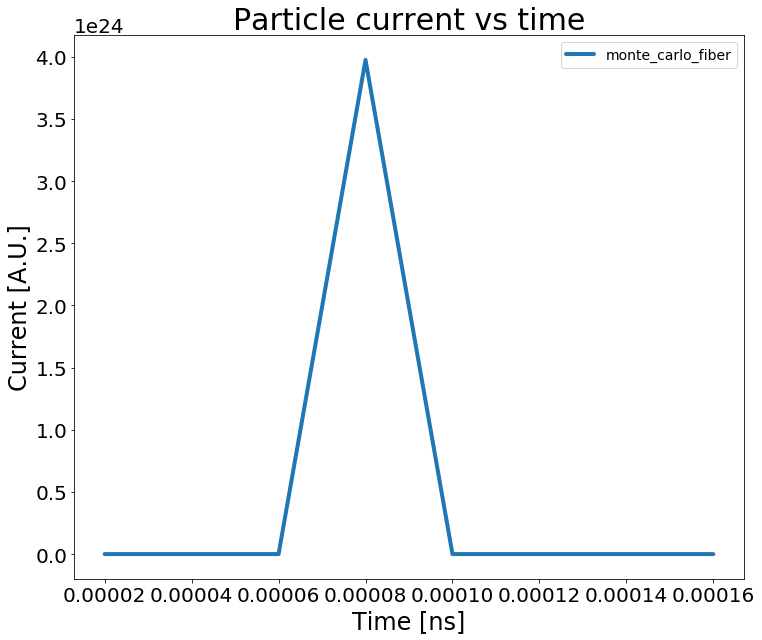

In [8]:
def plot_current(directory, box_size=200, color=None, ax=None):
    if (ax is None):
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(1,1,1)
    filename = os.path.join(directory, "region_current.dat")
    current = np.loadtxt(filename)
    time = current[:,0]
    current = current[:,1:]
    
    assert (current.shape[0] > box_size), "box_size must be smaller than the number of time steps: {}".format(current.shape[0])

    # calculate and plot box average of the data
    box = np.ones(box_size)
    smooth_current = np.zeros((current.shape[0]-box.shape[0]+1,current.shape[1]))
    for i in range(0,current.shape[1]):
        smooth_current[:,i] = np.convolve(current[:,i], box, mode='valid')/np.sum(box)
        
    print("steady state drain current: {:.2e}".format(smooth_current[-1,2]))
    steady_current = smooth_current[-1,2]
        
    ax.plot(time[:smooth_current.shape[0]]*1.e9,(smooth_current[:,2]), linewidth=4, color=color)
    ax.set_title("Particle current vs time",fontsize=30)
    ax.set_xlabel("Time [ns]",fontsize=24)
    ax.set_ylabel("Current [A.U.]",fontsize=24)
    ax.tick_params(labelsize=20)
    return steady_current


current = np.array([])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
legends = []
for d in directories:
    c = plot_current(d, ax=ax, box_size=1)
    current = np.append(current,c)
    legends.append(os.path.basename(d))
_ = ax.legend(legends, fontsize=14)
# ax.set_xlim([0,0.1])


# Population profile versus time

length of population array: 8


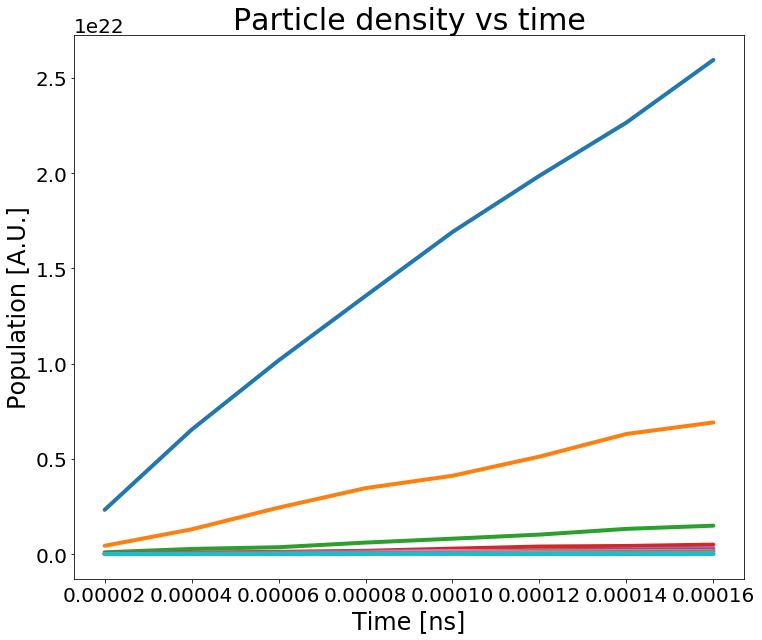

In [10]:
def plot_population_vs_time(directory, box_size=10, color=None, ax=None):
    if (ax is None):
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(1,1,1)
    filename = os.path.join(directory, "population_profile.dat")
    population = np.loadtxt(filename)
    distance = population[0,1:]
    time = population[1:,0]
    population = population[1:,1:]
    print("length of population array: {}".format(population.shape[0]))
    
    assert (population.shape[0] > box_size), "box_size must be smaller than the number of time steps: {}".format(current.shape[0])

    # calculate and plot box average of the data
    box = np.ones(box_size)
    smooth_population = np.zeros((population.shape[0]-box.shape[0]+1,population.shape[1]))
    for i in range(0,population.shape[1]):
        smooth_population[:,i] = np.convolve(population[:,i], box, mode='valid')/np.sum(box)
        
    ax.plot(time[:smooth_population.shape[0]]*1.e9,(smooth_population[:,:]), linewidth=4, color=color)
    _ = ax.set_title("Particle density vs time",fontsize=30)
    _ = ax.set_xlabel("Time [ns]",fontsize=24)
    _ = ax.set_ylabel("Population [A.U.]",fontsize=24)
    _ = ax.tick_params(labelsize=20)
    return ax

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
_ = plot_population_vs_time(directories[0],ax=ax, box_size=1)

# Population profile versus position

length of population array: 8
time: 0.09
dn/dx = 1.24e+29



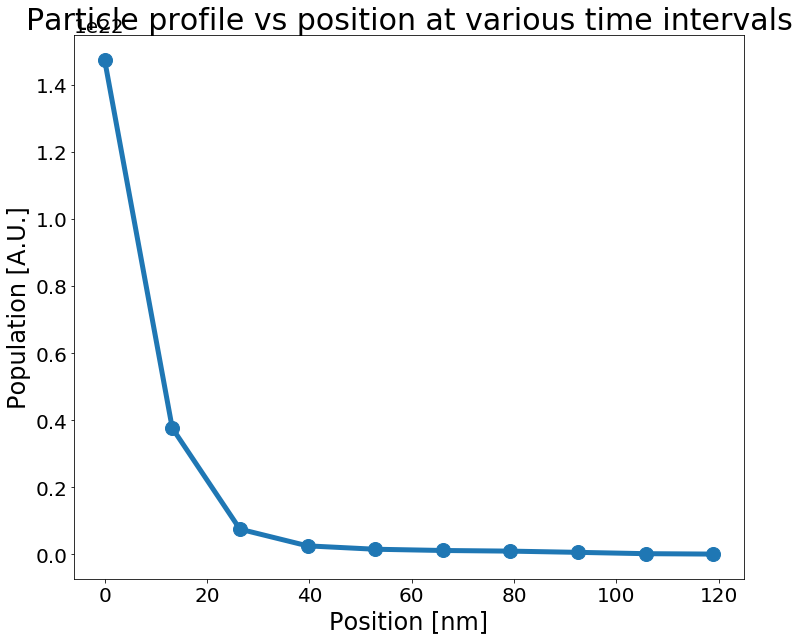

In [11]:
def plot_population_vs_position(directory, start=0, end=None, color=None, ax=None):
    if (ax is None):
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(1,1,1)
    filename = os.path.join(directory, "population_profile.dat")
    population = np.loadtxt(filename)
    distance = population[0,1:]
    time = population[1:,0]
    population = population[1:,1:]
    print("length of population array: {}".format(population.shape[0]))
    
    if (end is None):
        end = population.shape[0]
    
#     assert (population.shape[0] > start), "start interval must be smaller than the number of time steps: {}".format(population.shape[0])
    avg_population = np.mean(population[start:end,:],0)
        
    ax.plot(distance*1.e9, avg_population, linewidth=5, marker='o', markersize=14, color=color)
    ax.set_title("Particle profile vs position",fontsize=30)
    ax.set_xlabel("Position [nm]",fontsize=24)
    ax.set_ylabel("Population [A.U.]",fontsize=24)
    ax.tick_params(labelsize=20)
    print("time: {}".format(np.mean(time[start:end])*1.e12))
    density_gradient = abs((avg_population[0]-avg_population[-1])/(distance[0]-distance[-1]))
    print("dn/dx = {:0.2e}\n".format(density_gradient))
    return density_gradient

density_gradient = np.array([])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
for d in directories:
    grad = plot_population_vs_position(d, start=-2000,end=None,ax=ax)
    density_gradient = np.append(density_gradient,grad)

_ = ax.set_title("Particle profile vs position at various time intervals",fontsize=30)

# Calculate diffusion coefficient
$$ D = J/\big(\frac{dn}{dx}\big) $$
has units of [$\text{m}^2/\text{s}$]

ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

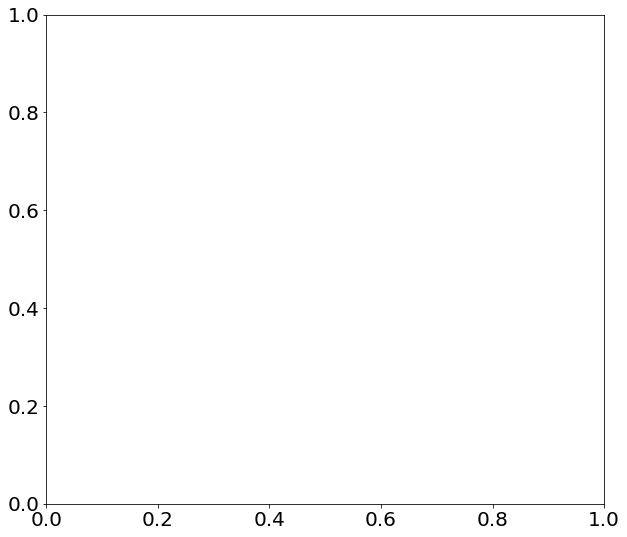

In [12]:
diff_coef = np.divide(current,density_gradient)
# x_axis = np.array(range(len(diff_coef)))
x_axis = np.array([5,10,15,20])

fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1,1,1)
ax.plot(x_axis, diff_coef[:len(x_axis)]*1.e4, linewidth=4, marker='o', markersize='14')

ax.axhline(y=diff_coef[-1]*1.e4, linewidth=4, color='red', linestyle='dashed')

ax.set_title("Diffusion coefficient", fontsize=30)
ax.set_ylabel("Diffusion coeffitient [cm$^2$/s]",fontsize=24)
ax.set_xlabel("Length of CNT section [nm]",fontsize=24)
ax.tick_params(labelsize=20)
ax.set_xlim([4.8,20.2])
ax.legend(['fixed section length', 'random section length\nbetween 5 nm and 20 nm'], fontsize=24)